# Using TensorNet (Advanced)

This notebook will demonstrate implementation of some of the advanced concepts in Deep Learning using Tensornet:

- Using One Cycle Policy for training
- Running LR Range Test to find the learning rate boundaries for the One Cycle Policy
- Displaying Gradient-weighted Class Activation Maps (GradCAM)

# Installing Packages

In [ ]:
!pip install --no-cache-dir torch-tensornet

# Imports
Importing necessary packages and modules

In [18]:
%matplotlib inline

import random
import matplotlib.pyplot as plt

from tensornet.data import CIFAR10
from tensornet.models import resnet18
from tensornet.models.loss import cross_entropy_loss
from tensornet.models.optimizer import sgd
from tensornet.engine import LRFinder
from tensornet.gradcam import GradCAMView
from tensornet.utils import initialize_cuda, plot_metric, get_predictions, save_and_show_result
from tensornet.engine.ops.lr_scheduler import OneCycleLR

## Set Seed and Get GPU Availability

In [2]:
# Initialize CUDA and set random seed
cuda, device = initialize_cuda(1)  # random seed is set to 1

GPU Available? True


## Setup Dataset

Downloading and initializing `CIFAR-10` dataset and applying the following augmentations:
- Horizontal Flip
- Random Rotation
- Cutout Augmentation

In [3]:
dataset = CIFAR10(
    train_batch_size=128,
    val_batch_size=128,
    cuda=cuda,
    num_workers=4,
    horizontal_flip_prob=0.2,
    rotate_degree=20,
    cutout_prob=0.3,
    cutout_dim=(8, 8),
)

Files already downloaded and verified
Files already downloaded and verified


## Data Visualization
Let's see how our data looks like. This information will help us decide the transformations that can be used on the dataset.

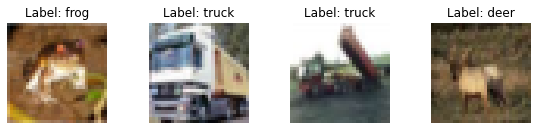

In [4]:
# Fetch data
classes = dataset.classes
sample_data, sample_targets = dataset.data()

# Set number of images to display
num_images = 4

# Display images with labels
fig, axs = plt.subplots(1, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(num_images):
    axs[i].axis('off')
    axs[i].set_title(f'Label: {classes[sample_targets[i]]}')
    axs[i].imshow(sample_data[i])

## Training and Validation Dataloaders
This is the final step in data preparation. It sets the dataloader arguments and then creates the dataloader

In [5]:
# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

# Model Architecture and Summary

We'll download a pretrained ResNet18 model and train it on our dataset using fine-tuning.

In [6]:
model = resnet18(pretrained=True).to(device)  # Create model
model.summary(dataset.image_size)  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

# Learning Rate Range Test
This range test will be used to determine the minimum and maximum value that we are going to use for One Cycle Policy for Learning Rate

In [7]:
start_lr = 1e-6
end_lr = 0.02
num_iterations = 10 * len(train_loader)  # 10 epochs

# Create optimizer
# Optimizer contains L2 regularization
optimizer = sgd(model, learning_rate=start_lr, momentum=0.9, l2_factor=0.01)

# Create Loss Function
criterion = cross_entropy_loss()

# LR Range Test
lr_finder = LRFinder(model, optimizer, criterion, metric='accuracy', device=device)
lr_finder.range_test(
    train_loader, num_iterations, mode='iteration',
    end_lr=end_lr, step_mode='linear', diverge_th=0
)

Iterations
3910/3910 [========] - 198s 51ms/step - lr: 0.0100 - Accuracy: 62.0908
Learning rate search finished.


Learning Rate: 0.0125
Accuracy: 0.69


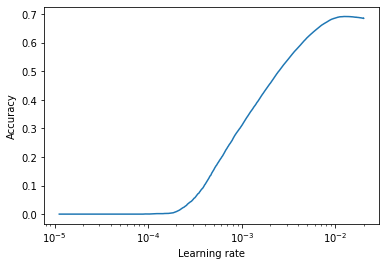

In [8]:
# Get best maximum learning rate
max_lr = lr_finder.best_lr

print(f'Learning Rate: {max_lr:.4f}')
print(f'Accuracy: {lr_finder.best_metric:.2f}')

# Plot learning rate vs accuracy
lr_finder.plot()

# Reset graph
lr_finder.reset()

## One Cycle Policy for Learning Rate

The model will be trained for 24 epochs. For the first 5 epochs, the learning rate will increase and for the later epochs, the learning rate will decrease.

By setting, `final_div_factor` as 1, we are ensuring that there is no annealing of the learning rate at the end of the training.

The *min_lr* is set to be 1/10<sup>th</sup> of the *max_lr*.

In [9]:
epochs = 24

# Define one cycle policy
one_cycle_policy = OneCycleLR(
    optimizer, max_lr, epochs=epochs,
    steps_per_epoch=len(train_loader), pct_start=5/epochs,
    div_factor=10, final_div_factor=1
)

# Model Training and Validation

In [10]:
model.fit(
    train_loader,
    optimizer,
    criterion,
    device=device,
    epochs=epochs,
    val_loader=val_loader,
    callbacks=[one_cycle_policy]
)

Epoch 1:
391/391 [========] - 20s 50ms/step - loss: 1.5101
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0064

Epoch 2:
391/391 [========] - 20s 50ms/step - loss: 0.7968
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0057

Epoch 3:
391/391 [========] - 20s 51ms/step - loss: 0.7107
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0057

Epoch 4:
391/391 [========] - 20s 51ms/step - loss: 0.7198
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0070

Epoch 5:
391/391 [========] - 20s 51ms/step - loss: 0.7564
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0069

Epoch 6:
391/391 [========] - 20s 51ms/step - loss: 0.7792
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0071

Epoch 7:
391/391 [========] - 20s 51ms/step - loss: 0.7997
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0064

Epoch 8:
391/391 [========] - 20s 52ms/step - loss: 0.7957
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0072



## Plotting Results

Plot changes in validation loss

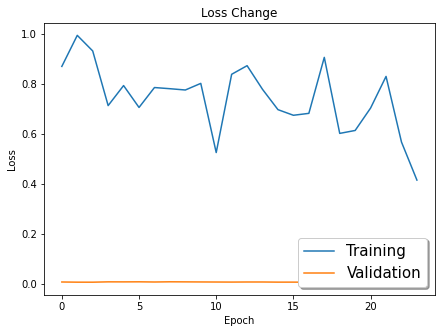

In [12]:
plot_metric({
    'Training': model.learner.train_losses,
    'Validation': model.learner.val_losses
}, 'Loss')

## Model Predictions
Get model predictions on the validation dataset

In [13]:
correct_samples, incorrect_samples = get_predictions(model, val_loader, device)

### GradCAM

Let's display GradCAM of any random 2 correctly predicted samples.

In [14]:
def plot_view(layers, view, fig, row_num, ncols, metric):
    """Plot a CAM view.

    Args:
        layers: List of layers
        view: Dictionary containing image, heatmap and result.
        fig: Matplotlib figure instance.
        row_num: Row number of the subplot.
        ncols: Total number of columns in the subplot.
        metric: Can be one of ['heatmap', 'result'].
    """
    sub = fig.add_subplot(row_num, ncols, 1)
    sub.axis('off')
    plt.imshow(view['image'])
    sub.set_title(f'{metric.title()}:')
    for idx, layer in enumerate(layers):
        sub = fig.add_subplot(row_num, ncols, idx + 2)
        sub.axis('off')
        plt.imshow(view[metric][layer])
        sub.set_title(layer)

    
def plot_gradcam(views, layers, plot_path):
    """Plot heatmap and CAM result.

    Args:
        plot_path: Path to save the plot.
        layers: List of layers.
        view: List of dictionaries containing image, heatmap and result.
    """

    for idx, view in enumerate(views):
        # Initialize plot
        fig = plt.figure(figsize=(10, 10))

        # Plot view
        plot_view(layers, view, fig, 1, len(layers) + 1, 'heatmap')
        plot_view(layers, view, fig, 2, len(layers) + 1, 'result')
        
        # Set spacing and display
        fig.tight_layout()
        plt.show()

        # Save image
        fig.savefig(f'{plot_path}_{idx + 1}.png', bbox_inches='tight')

        # Clear cache
        plt.clf()

In [19]:
layers = ['layer1', 'layer2', 'layer3', 'layer4']
grad_cam = GradCAMView(
    model, layers,
    device, dataset.mean, dataset.std
)

images = [x['image'] for x in random.sample(correct_samples, 4)]
gradcam_views = grad_cam(images)

Mode set to GradCAM.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


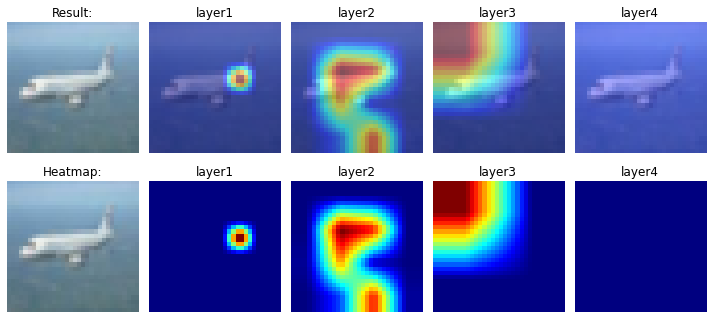

<Figure size 432x288 with 0 Axes>

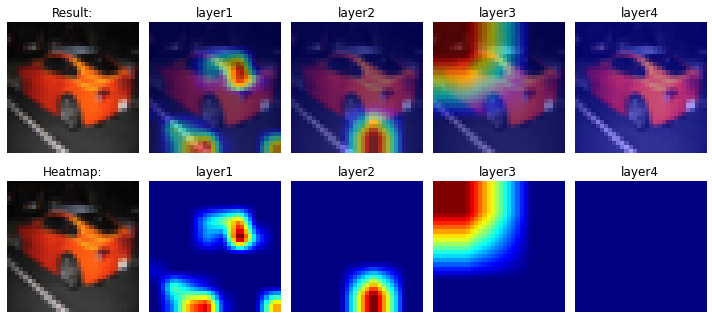

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

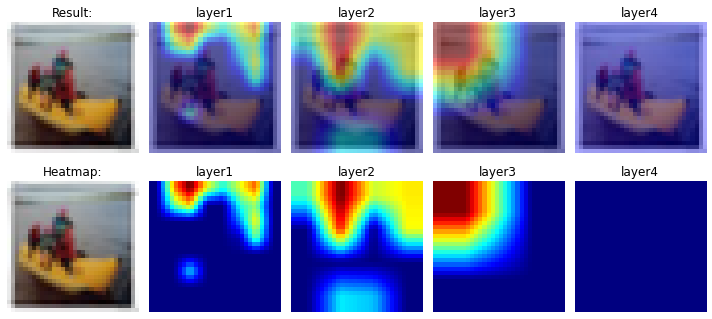

<Figure size 432x288 with 0 Axes>

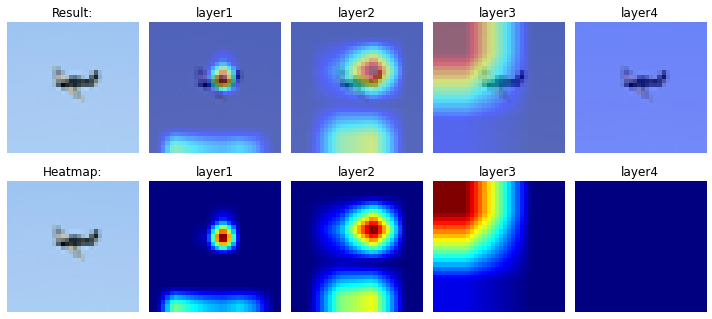

<Figure size 432x288 with 0 Axes>

In [20]:
plot_gradcam(gradcam_views, layers, 'grad_cam')

## Display Correct and Incorrect Predictions

In [21]:
# This cell will take some time to run

# Unnormalize correct samples
for idx in range(len(correct_samples)):
    correct_samples[idx]['image'] = dataset.unnormalize(correct_samples[idx]['image'], transpose=True)

# Unnormalize incorrect samples
for idx in range(len(incorrect_samples)):
    incorrect_samples[idx]['image'] = dataset.unnormalize(incorrect_samples[idx]['image'], transpose=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


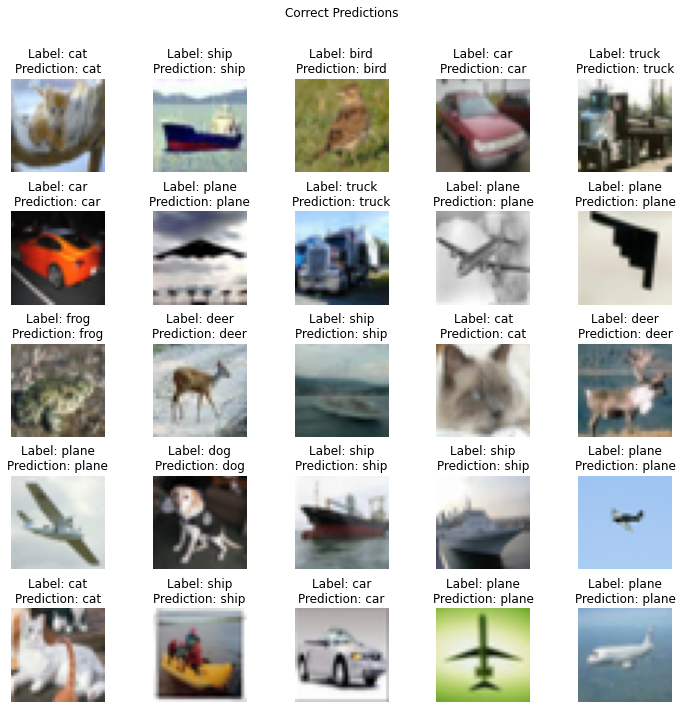

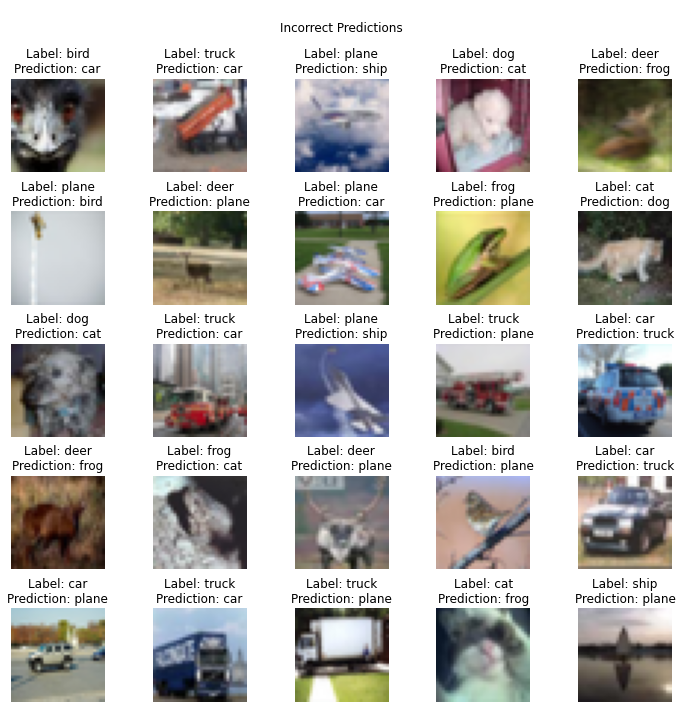

In [22]:
save_and_show_result(classes, correct_samples, incorrect_samples, path='predictions')